# 5G user predictor

## Prework

In [1]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 创建函数 用户求解 ROC 值并绘图
def plot_roc_curve(y_test, y_pred_proba, title):
    # 计算ROC曲线和AUC值
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Random Forest

Before weighing Random Forest AUC Score: 0.8487879588206548


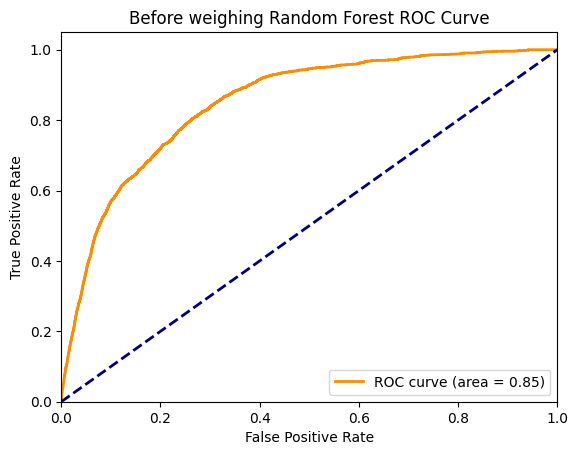

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 加载数据
df = pd.read_csv(r"./train.csv", header=0)

# 数据预处理
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# 划分特征和目标变量
X = df.drop(['id','target'], axis=1)
y = df['target']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 不进行加权 就训练
rf_classifier = RandomForestClassifier(max_depth=2, n_estimators=100, random_state=42)

# 训练模型
rf_classifier.fit(X_train, y_train)

# 预测测试集
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# 评估模型
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'Before weighing Random Forest AUC Score: {auc_score}')
plot_roc_curve(y_test, y_pred_proba, 'Before weighing Random Forest')

改进随机森林

After Weighing Random Forest AUC Score: 0.864324531731457


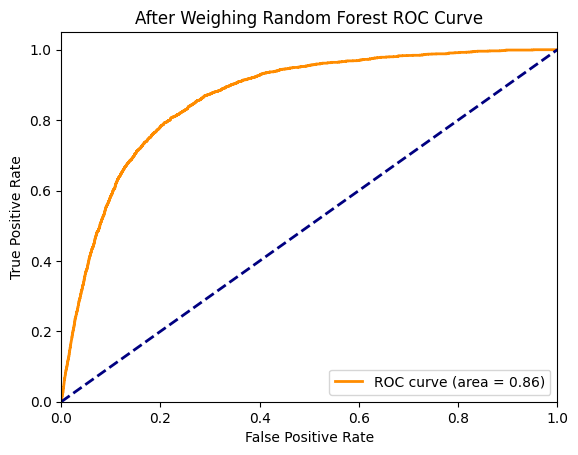

   feature  importance
57  num_37    0.212959
23   num_3    0.136986
24   num_4    0.112694
12  cat_12    0.087819
30  num_10    0.086903
1    cat_1    0.073404
0    cat_0    0.052754
52  num_32    0.047117
11  cat_11    0.037912
50  num_30    0.019730


In [4]:
# 发现 y 值分布极其不平衡 对 RF 模型进行改进
# 设置权重
class_weights = dict(1 / y_train.value_counts())

# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(max_depth=2, n_estimators=100, random_state=42, class_weight=class_weights)

# 训练模型
rf_classifier.fit(X_train, y_train)

# 预测测试集
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# 评估模型
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'After Weighing Random Forest AUC Score: {auc_score}')
plot_roc_curve(y_test, y_pred_proba, 'After Weighing Random Forest')

feature_importances = rf_classifier.feature_importances_
features = X.columns

# 输出最重要的十个特征值
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
print(importance_df.sort_values('importance', ascending=False).head(10))

## Decision Tree

Decision Tree AUC Score: 0.8555258121312662


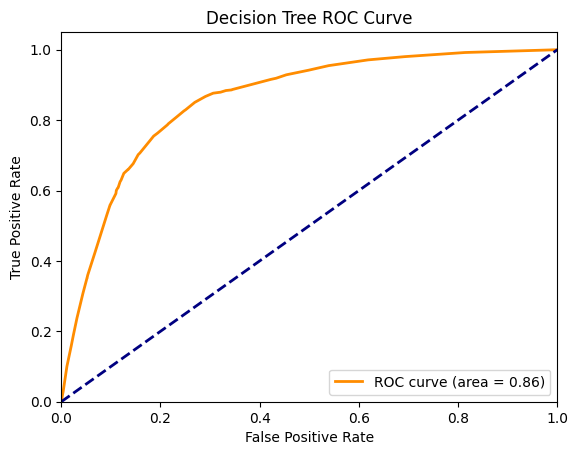

   feature  importance
4    num_3    0.349067
0    cat_0    0.272950
1    cat_1    0.232063
11  num_10    0.058581
3    num_0    0.028117
24  num_32    0.017671
28  num_36    0.012362
22  num_30    0.011101
17  num_22    0.006624
12  num_11    0.005540


In [5]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# 读取CSV文件
data = pd.read_csv(r"./train.csv", header=0)

# 处理缺失值
data.dropna(inplace=True)

# 提取特征和标签
X = data.drop(['id', 'target'], axis=1)
y = data['target']

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用方差阈值进行特征选择
threshold = 6.0
selector = VarianceThreshold(threshold=threshold)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# 获得被选择的特征的列索引
selected_columns = selector.get_support(indices=True)

# 创建决策树分类器并调整参数
clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42)

# 在选择的特征上训练决策树模型
clf.fit(X_train_selected, y_train)

# 使用训练好的模型进行预测
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]

# 计算AUC值
auc_score = roc_auc_score(y_test, y_pred_proba)
print('Decision Tree AUC Score:', auc_score)
plot_roc_curve(y_test, y_pred_proba, 'Decision Tree')

# 获取特征重要性
feature_importances = clf.feature_importances_

# 将特征重要性与特征名称对应起来，并创建DataFrame
importance_df = pd.DataFrame({
    'feature': X.columns[selected_columns],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# 打印最重要的十个特征
print(importance_df.head(10))

Decision Tree AUC Score: 0.8560527236299519


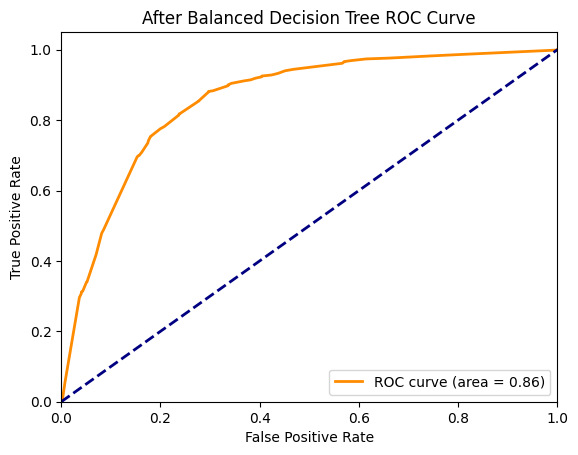

In [6]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier

# 同样 选择y值相当的数据作为训练数据
cnt = y.value_counts()
f0 = data.loc[data['target'] == 0.0, :].sample(cnt[1.0])
f1 = data.loc[data['target'] == 1.0, :]
ddf = pd.concat([f0, f1], axis=0)

X = ddf.drop(columns=['target'])
y = ddf.loc[:, 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用方差阈值进行特征选择
threshold = 6.0
selector = VarianceThreshold(threshold=threshold)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# 获得被选择的特征的列索引
selected_columns = selector.get_support(indices=True)

# 创建决策树分类器并调整参数
clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42)

# 在选择的特征上训练决策树模型
clf.fit(X_train_selected, y_train)

# 使用训练好的模型进行预测
y_pred = clf.predict(X_test_selected)

# 计算预测概率
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('Decision Tree AUC Score:', auc_score)
# 评价 roc
plot_roc_curve(y_test, y_pred_proba, 'After Balanced Decision Tree')

## Neural Network

2024-06-04 13:18:24.466641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-04 13:18:24.466678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-04 13:18:38.793868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-04 13:18:38.793896: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-04 13:18:38.793914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-edbecf): /proc/driver/nvidia/version does not exist
2024-06-04 13:18:38.794097: I tensorflow/core/platform/cpu_

Epoch 1/10


2024-06-04 13:18:38.968269: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 915456000 exceeds 10% of free system memory.


16000/16000 [==============================] - 17s 988us/step - loss: 0.0617 - accuracy: 0.9867 - val_loss: 0.0593 - val_accuracy: 0.9870
Epoch 2/10
16000/16000 [==============================] - 16s 979us/step - loss: 0.0594 - accuracy: 0.9867 - val_loss: 0.0591 - val_accuracy: 0.9870
Epoch 3/10
16000/16000 [==============================] - 16s 981us/step - loss: 0.0586 - accuracy: 0.9867 - val_loss: 0.0588 - val_accuracy: 0.9870
Epoch 4/10
16000/16000 [==============================] - 16s 983us/step - loss: 0.0581 - accuracy: 0.9867 - val_loss: 0.0594 - val_accuracy: 0.9870
Epoch 5/10
16000/16000 [==============================] - 16s 984us/step - loss: 0.0576 - accuracy: 0.9867 - val_loss: 0.0592 - val_accuracy: 0.9870
Epoch 6/10
16000/16000 [==============================] - 16s 984us/step - loss: 0.0573 - accuracy: 0.9867 - val_loss: 0.0590 - val_accuracy: 0.9870
Epoch 7/10
16000/16000 [==============================] - 16s 985us/step - loss: 0.0569 - accuracy: 0.9867 - val_loss

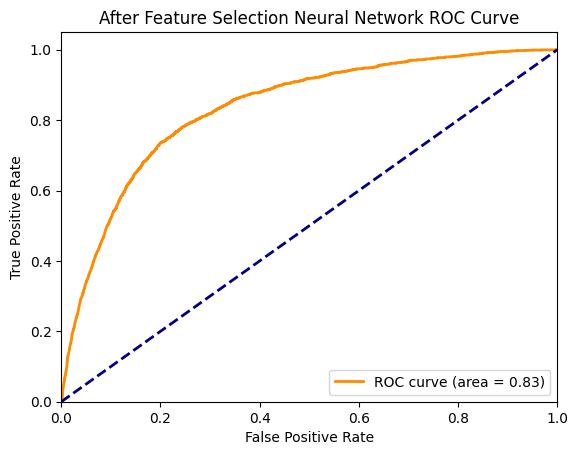

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# 读取数据集
data = pd.read_csv(r"train.csv", header=0)

# 处理缺失值，将包含缺失值的行删除
data.dropna(inplace=True)

# 划分特征变量和目标变量
# 移除'id'和'target'列，保留特征列
X = data.drop(['id', 'target'], axis=1)
# 选取'target'列作为目标变量
y = data['target']

# 选择一些分类特征进行训练
# 假设前10个特征是分类特征，将它们命名为cat_features列表
cat_features = ['cat_{}'.format(i) for i in range(10)]
# 从特征数据X中选择这些分类特征
X = X[cat_features]

# 对离散特征进行独热编码处理
# 将分类特征转换为机器学习算法可以更好处理的形式
X = pd.get_dummies(X, columns=cat_features)

# 数据标准化处理，使特征值在0-1之间
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
# 按照80%的数据用于训练，20%的数据用于测试的比例划分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 构建神经网络模型
# 使用Sequential模型，这是一种线性堆叠的层次模型
model = Sequential()
# 添加第一个全连接层，64个神经元，激活函数为ReLU
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
# 添加第二个全连接层，64个神经元，激活函数为ReLU
model.add(Dense(64, activation='relu'))
# 添加输出层，1个神经元，激活函数为Sigmoid，适用于二分类问题
model.add(Dense(1, activation='sigmoid'))

# 编译模型
# 指定损失函数为binary_crossentropy，优化器为adam，评价指标为accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
# 使用训练集数据训练模型，批大小为32，迭代10轮，使用验证集比例为20%
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# 在测试集上进行预测
y_pred_proba = model.predict(X_test)

# 计算AUC指标
plot_roc_curve(y_test, y_pred_proba, 'After Feature Selection Neural Network')

改进之后的NN